In [175]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.utils import resample

In [176]:
#Read the dataset
df = pd.read_csv('DataQN-for-ML.csv')
df['time'] = pd.to_datetime(df['time'], format='mixed', utc=True)
df['time'] = df['time'].astype(str)
df.shape

(8760, 8)

In [177]:
df.head()

,time,rain_fall,temp,humidity,wind_direction,wind_speed,rain_now,rain_next_hour
0,2017-01-01 00:00:00+00:00,2.3,21.9,96.0,NaN,NaN,Yes,Yes
1,2017-01-01 01:00:00+00:00,1.7,21.9,96.0,WNW,1.0,Yes,No
2,2017-01-01 02:00:00+00:00,0.0,21.9,96.0,NaN,NaN,No,Yes
3,2017-01-01 03:00:00+00:00,0.2,21.8,95.0,NaN,NaN,Yes,No
4,2017-01-01 04:00:00+00:00,0.0,21.8,95.0,NaN,NaN,No,Yes


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            8760 non-null   object 
 1   rain_fall       8760 non-null   float64
 2   temp            8760 non-null   float64
 3   humidity        8760 non-null   float64
 4   wind_direction  1460 non-null   object 
 5   wind_speed      1460 non-null   float64
 6   rain_now        8760 non-null   object 
 7   rain_next_hour  8760 non-null   object 
dtypes: float64(4), object(4)
memory usage: 547.6+ KB


In [179]:
#Check statistical measures of the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rain_fall,8760.0,0.350913,2.100442,0.0,0.0,0.0,0.00,58.8
temp,8760.0,26.886952,3.955504,17.0,24.3,26.5,29.30,38.7
humidity,8760.0,88.333562,8.810621,48.0,84.0,92.0,95.00,99.0
wind_speed,1460.0,1.000685,0.890510,0.0,0.0,1.0,1.25,5.0


In [180]:
#Check Null Values
df.isnull().sum()

time                 0
rain_fall            0
temp                 0
humidity             0
wind_direction    7300
wind_speed        7300
rain_now             0
rain_next_hour       0
dtype: int64

In [181]:
#Check Duplicate Values
df.duplicated().sum()

0

In [182]:
#Check unique values
df.nunique()

time              8760
rain_fall          151
temp               216
humidity            47
wind_direction      17
wind_speed           6
rain_now             2
rain_next_hour       2
dtype: int64

In [183]:
df['rain_now'].replace({'No': 0, 'Yes': 1},inplace = True)
df['rain_next_hour'].replace({'No': 0, 'Yes': 1},inplace = True)

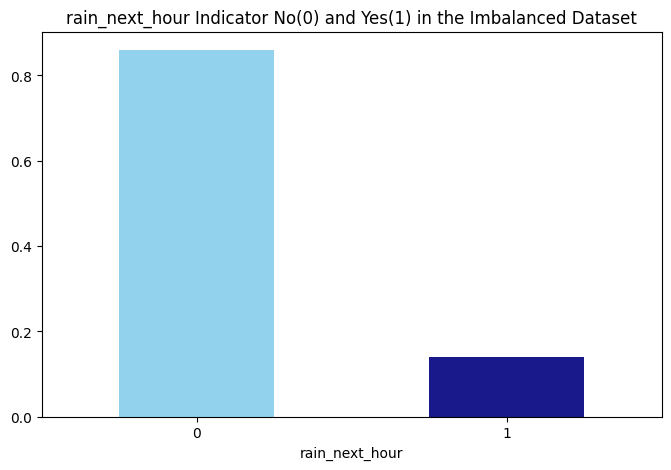

In [184]:
fig = plt.figure(figsize = (8,5))
df['rain_next_hour'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('rain_next_hour Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

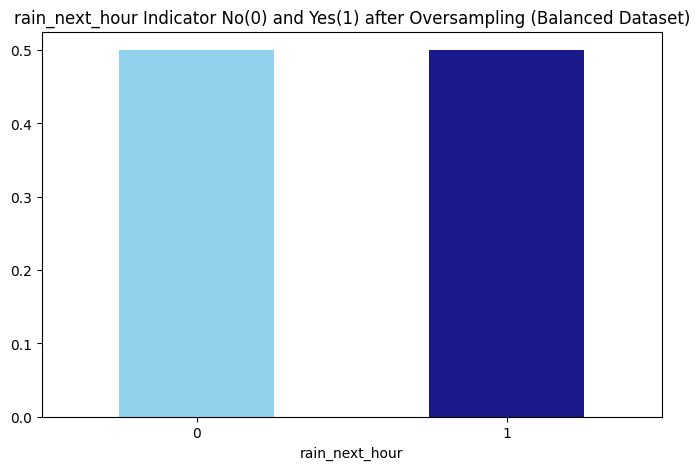

In [185]:
no = df[df.rain_next_hour == 0]
yes = df[df.rain_next_hour == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.rain_next_hour.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('rain_next_hour Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

<Axes: >

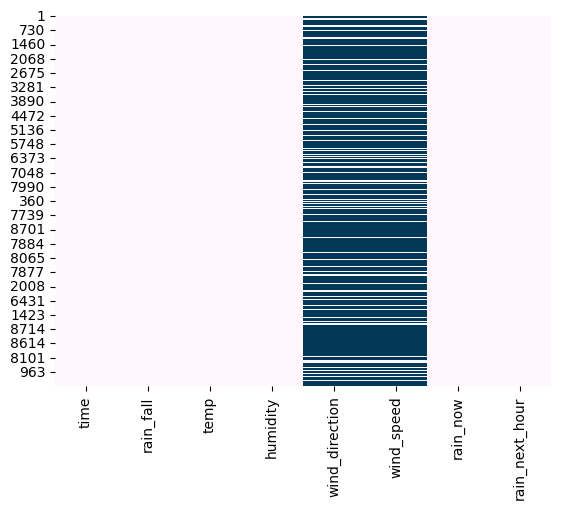

In [186]:
# Missing Data Pattern in Training Data
import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

In [187]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(8)

,Total,Percent
wind_direction,12508,0.830324
wind_speed,12508,0.830324
time,0,0.000000
rain_fall,0,0.000000
temp,0,0.000000
humidity,0,0.000000
rain_now,0,0.000000
rain_next_hour,0,0.000000


In [188]:
oversampled.select_dtypes(include=['object']).columns

Index(['time', 'wind_direction'], dtype='object')

In [189]:
# Impute categorical var with Mode
oversampled['time'] = oversampled['time'].fillna(oversampled['time'].mode()[0])
oversampled['wind_direction'] = oversampled['wind_direction'].fillna(oversampled['wind_direction'].mode()[0])

In [190]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [191]:
import warnings
warnings.filterwarnings("ignore")

In [192]:
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [193]:
MiceImputed.head()

,time,rain_fall,temp,humidity,wind_direction,wind_speed,rain_now,rain_next_hour
1,1,1.7,21.9,96.0,15,1.000000,1,0
3,3,0.2,21.8,95.0,13,0.674237,1,0
5,5,0.1,21.9,94.0,13,0.688999,1,0
6,6,0.0,22.3,94.0,13,0.536780,0,0
7,7,0.0,23.7,90.0,13,0.000000,0,0


In [194]:
MiceImputed.isna()

,time,rain_fall,temp,humidity,wind_direction,wind_speed,rain_now,rain_next_hour
1,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
7470,False,False,False,False,False,False,False,False
4924,False,False,False,False,False,False,False,False
1401,False,False,False,False,False,False,False,False
8634,False,False,False,False,False,False,False,False


In [195]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

time              5261.00000
rain_fall            0.50000
temp                 4.80000
humidity             9.00000
wind_direction       0.00000
wind_speed           0.30657
rain_now             1.00000
rain_next_hour       1.00000
dtype: float64


In [165]:
# Removing outliers from dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(10225, 8)

<Axes: >

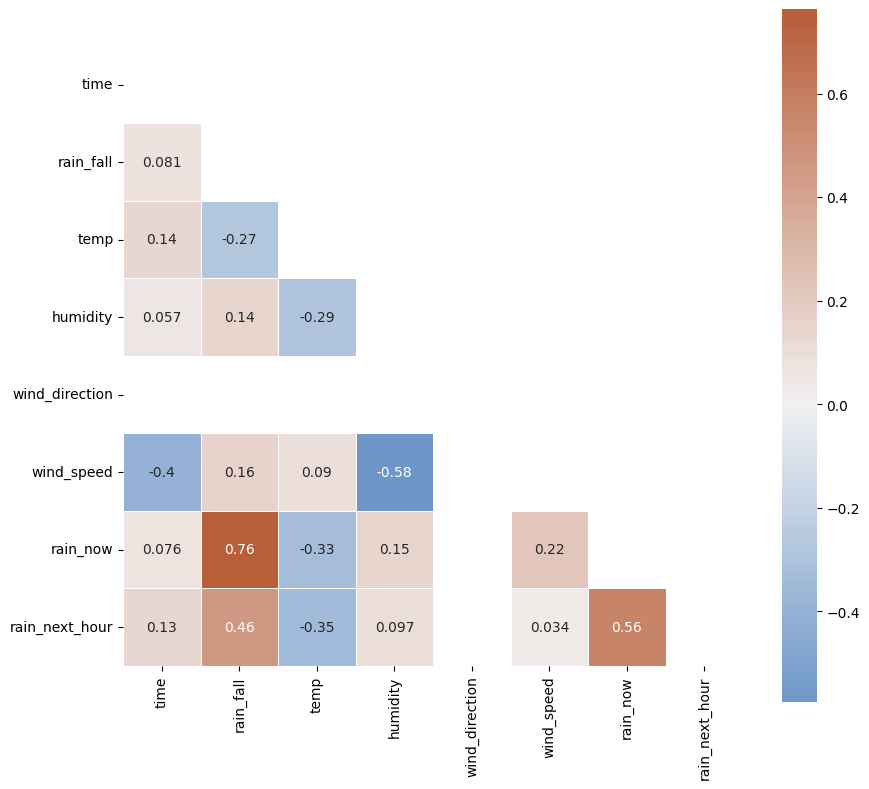

In [166]:
# Correlation Heatmap
import numpy as np
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

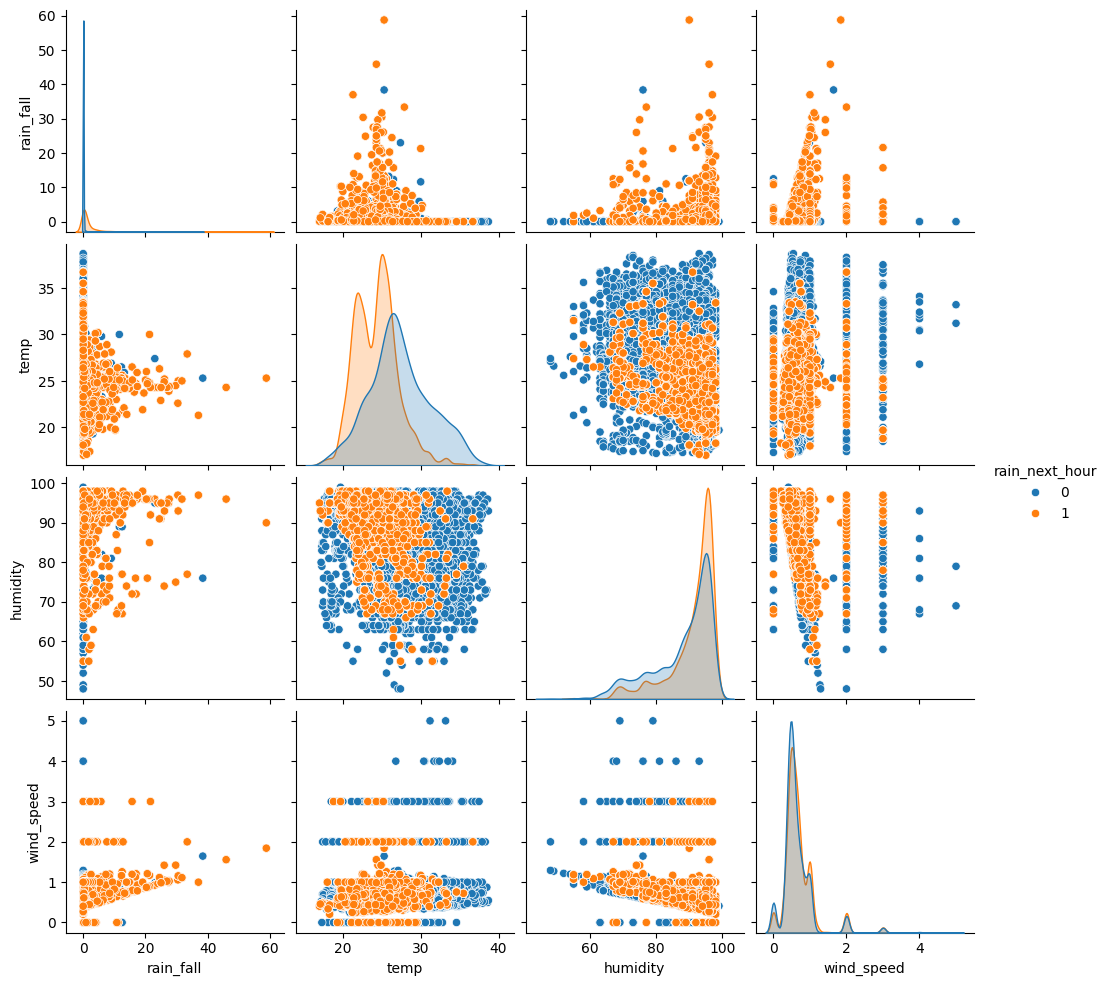

In [196]:
sns.pairplot( data=MiceImputed, vars=('rain_fall', 'temp', 'humidity', 'wind_speed'), hue='rain_next_hour' )